In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import csv
import pickle 
import copy 

import numpy as np
import random
import time

from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d


import sys
sys.path.insert(0, "../utils/")
from utils import predictionPlots, extractData, writeResult, R2

## Input options

In [3]:
features_names  = ['m1', 'm2', 's1x', 's1y', 's1z', 's2x', 's2y', 's2z', 'theta', 'q', 'Mc'];
regr_data_dir   = '../NewRealistic/'
write_output    = False
out_data_dir    = '../NN_results_SA/'
versions        = ['0'] # can be a subset of ['0', '1', '2']
clabels         = ['0'] # can be a subset of ['0', '1']

# sample size
Ntrain          = 20000;
Ntest           = 15000;

# hyperparameters, one for each dataset ( i.e. len(versions)*len(clables) ). IMPROVE ME 

## Check on input and dictionary-initialization

In [4]:
Nfeatures  = len(features_names)

# check that we are not exceeding the size of the datasets
Ntrain_max = 20000;
Ntest_max  = 15000;
Ntrain     = min(Ntrain, Ntrain_max)
Ntest      = min(Ntest,  Ntest_max )

# define dictionary for each version considered
Nv       = len(versions)
Nc       = len(clabels)
Nsets    = Nv*Nc

if Nv*Nc!=Nsets:
    print('+++ Wrong input! +++')

datasets = {}
keys     = []
for i in range(0,Nv):
    version = versions[i]
    for j in range(0,Nc):
        clabel = clabels[j]
        key = 'v'+version+'c'+clabel
        keys.append(key)
        datasets[key]         = lambda:0
        datasets[key].clabel  = clabel
        datasets[key].version = version
        datasets[key].Ntrain  = Ntrain
        datasets[key].Ntest   = Ntest

## Loop on versions

********************************************************************************
Key: v0c0
********************************************************************************
../NewRealistic/v0c0train_x.csv loaded
../NewRealistic/v0c0train_y.csv loaded
../NewRealistic/v0c0test_x.csv loaded
../NewRealistic/v0c0test_y.csv loaded

The gloal score is: 0.9480399274014407
R2[ 0]         : 0.99712
R2[ 1]         : 0.99585
R2[ 2]         : 0.93317
R2[ 3]         : 0.92883
R2[ 4]         : 0.93093
R2[ 5]         : 0.93089
R2[ 6]         : 0.93209
R2[ 7]         : 0.93276
R2[ 8]         : 0.85284
R2[ 9]         : 0.99512
R2[10]         : 0.99885


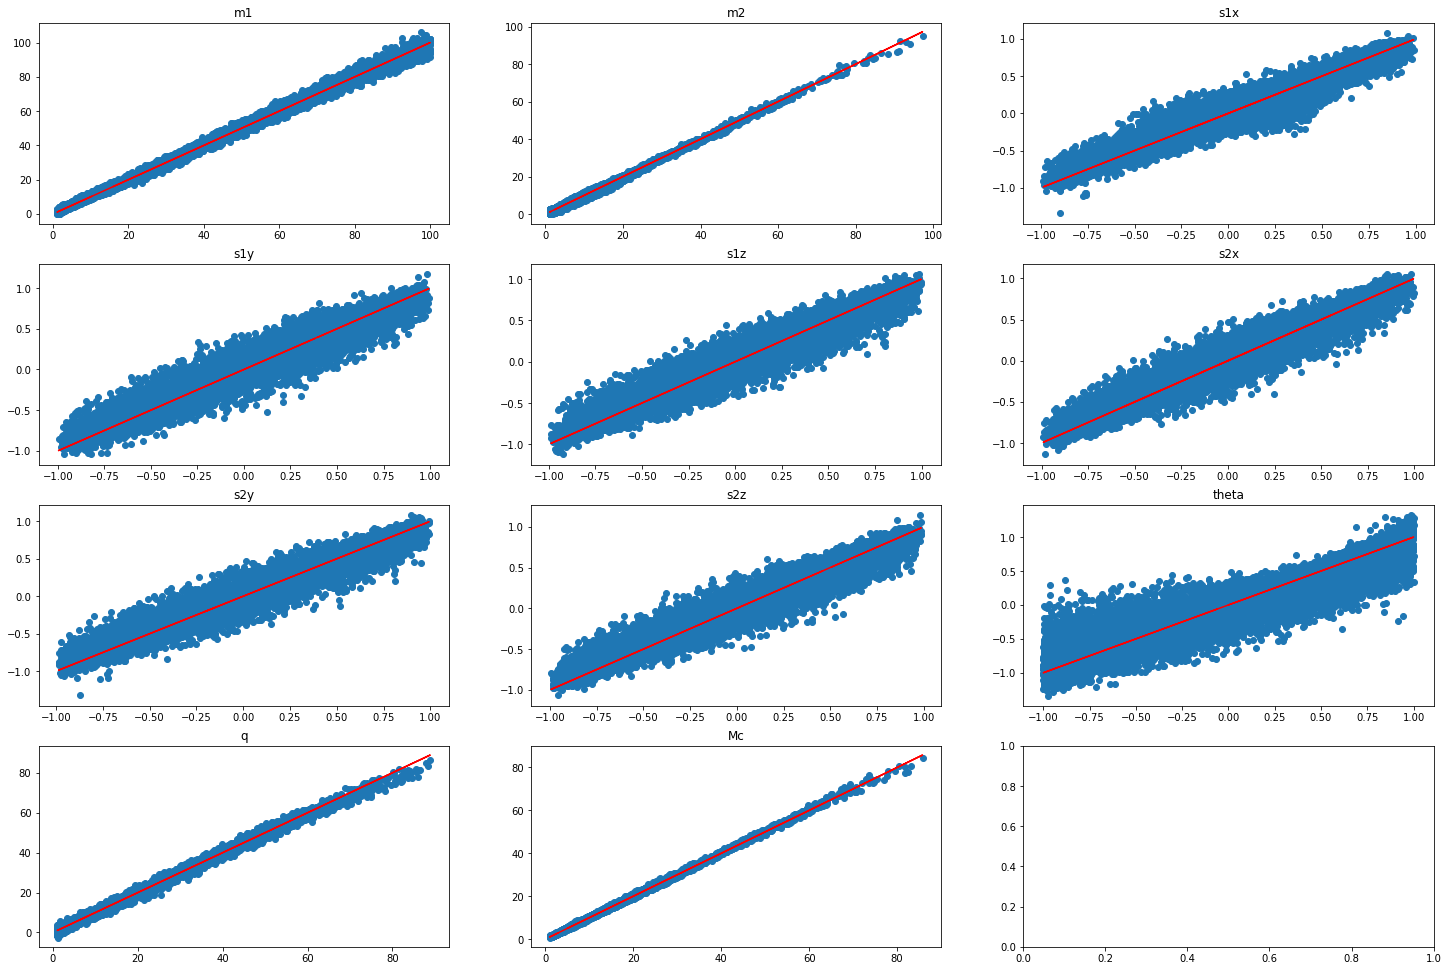

In [5]:
dashes = '*'*80

for key in keys:
    print(dashes, '\nKey: ', key, '\n', dashes, sep='')
        
    # Load all the data for the specific version
    xtrain_tot = extractData(regr_data_dir+key+'train_x.csv', verbose=True)
    ytrain_tot = extractData(regr_data_dir+key+'train_y.csv', verbose=True)
    xtest_tot  = extractData(regr_data_dir+key+'test_x.csv' , verbose=True)
    ytest_tot  = extractData(regr_data_dir+key+'test_y.csv' , verbose=True)
    
    # select a subset according to the input
    xtrain_notnormalized = xtrain_tot[0:Ntrain,:]
    ytrain_notnormalized = ytrain_tot[0:Ntrain,:]
    xtest_notnormalized  = xtest_tot[0:Ntest,:]
    ytest_notnormalized  = ytest_tot[0:Ntest,:]
    
    scaler_x = StandardScaler().fit(xtrain_notnormalized)
    scaler_y = StandardScaler().fit(ytrain_notnormalized)
    xtrain   = scaler_x.transform(xtrain_notnormalized)
    ytrain   = scaler_y.transform(ytrain_notnormalized)
    xtest    = scaler_x.transform(xtest_notnormalized)
    ytest    = scaler_y.transform(ytest_notnormalized)

    t0         = time.perf_counter()
    model      = MLPRegressor(random_state=1, max_iter=500, activation='tanh', solver='adam')
    regr       = model.fit(xtrain, ytrain)
    score      = regr.score(xtest, ytest);
    train_time = time.perf_counter()-t0
    ypredicted = regr.predict(xtest)
    
    print('\nThe gloal score is:', score)
    for i in range(0,Nfeatures):
        print('R2[{:2d}]         : {:.5f}'.format(i, R2(ytest[:,i],ypredicted[:,i])))
        
    # update dictionary adding data (both normalized and not), model and score
    datasets[key].train_time = train_time
    datasets[key].score      = score
    datasets[key].regr       = regr

    # plot
    predictionPlots(scaler_y.inverse_transform(ytest), 
                    scaler_y.inverse_transform(ypredicted), 
                    features_names)
    

In [6]:
# just a check to see if the dictionary is ok
#for key in keys:
#    print('\nCheck on dictionary, everything should be 0:')
#    for i in range(0, Nfeatures):
#        model = datasets[key].models[i]
#        model.score(xtest, datasets[key].ytest[:,i])
#        print('#{:2d}: {:.5f}'.format(i, datasets[key].scores[i]- \
#                    model.score(datasets[key].xtest_normalized, datasets[key].ytest_normalized[:,i])))

## Produce CSV files and save models

In [7]:
if write_output:
    for key in keys:
        # save csv
        filename = out_data_dir+'NNsklearn_'+key+'.csv'
        writeResult(filename, datasets[key].predicted, verbose=True)
        
        # save model
        dict_name = out_data_dir+'NNsklearn_'+key+'_dict.sav'
        pickle.dump(datasets[key].models, open(dict_name, 'wb'))
        print(dict_name, 'saved') 
        
        # example for loading models
        dict_name    = out_data_dir+'NNsklearn_'+key+'_dict.sav'
        print('Loading', dict_name, '...')
        loaded_model = pickle.load(open(dict_name, 'rb'))
        result       = loaded_model[1].score(datasets[key].xtest_normalized, datasets[key].ytest_normalized[:,1])
        print('Score for features #1 of the model ', key, ': ', result, '\n', sep='')